In [1]:
# !pip install peft
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from peft import LoraConfig, get_peft_model
import wandb

In [2]:
def get_image_paths_and_labels_from_df(df, data_dir):
    article_ids = df["article_id"].values
    image_paths = []
    labels = []
    
    for article_id in article_ids:
        image_path = f"{data_dir}/images/0{str(article_id)[:2]}/0{article_id}.jpg"
        # Check if the image file exists
        if os.path.exists(image_path):
            image_paths.append(image_path)
            # Add corresponding label only if the image exists
            labels.append(df[df["article_id"] == article_id])

    return image_paths, labels

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, processor=None):
        self.image_paths = image_paths
        self.processor = processor
        self.image_ids = []

        for image_path in self.image_paths:
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"Image {image_path} not found.")
            else:
                image_id = int(image_path.split("/")[-1].split(".")[0])
                self.image_ids.append(image_id)
            

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.processor is not None:
            inputs = self.processor(images=image, return_tensors="pt", padding=True)
            image = inputs["pixel_values"][0]
        return image, self.image_ids[idx]

In [3]:
torch.manual_seed(42)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", cache_dir="model", local_files_only=False)

/home/user/miniforge3/envs/hf/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
# text_path = '/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv'
text_path = 'data/articles.csv'
articles = pd.read_csv(text_path)
data_dir = 'data'

In [6]:
# map from article_id to df index
article_id_to_idx = {article_id: idx for idx, article_id in enumerate(articles["article_id"])}

# get all classes of the dataframe
class_names = articles.columns.tolist()
label_names = dict()
label_names_to_idx = dict()
for class_name in class_names:
    label_names[class_name] = articles[class_name].unique()
    label_names_to_idx[class_name] = {label_name: idx for idx, label_name in enumerate(label_names[class_name])}

article_ids = label_names["article_id"]
#selected_class_names = ["product_type_name", "graphical_appearance_name"]
selected_class_names = ["product_group_name", "product_type_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]

In [7]:
# grouped by product_code
grouped = articles.groupby("product_code")
groups = [group for _, group in grouped]

# split 0.8/0.1/0.1
train_groups, test_groups = train_test_split(groups, test_size=0.2, random_state=42) 
val_groups, test_groups = train_test_split(test_groups, test_size=0.5, random_state=42) 

train_df = pd.concat(train_groups)
val_df = pd.concat(val_groups)
test_df = pd.concat(test_groups)

print(f"{len(train_df)=} {len(val_df)=} {len(test_df)=}")

len(train_df)=84445 len(val_df)=10534 len(test_df)=10563


In [8]:
train_paths, train_labels = get_image_paths_and_labels_from_df(train_df, data_dir)
val_paths, val_labels = get_image_paths_and_labels_from_df(val_df, data_dir)
test_paths, test_labels = get_image_paths_and_labels_from_df(test_df, data_dir)

In [9]:
class MultiOutputLayer(torch.nn.Module):
    def __init__(self, input_size, inter_size, output_size):
        super(MultiOutputLayer, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, inter_size)
        self.fc2 = torch.nn.Linear(inter_size, output_size)
        self.dropout = torch.nn.Dropout(0.5)
        self.act = torch.nn.SiLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [10]:
class MultiOutputClipModel(torch.nn.Module):
    def __init__(self, clip_model, class_names, vision_hidden_size, inter_size, output_size):
        super(MultiOutputClipModel, self).__init__()
        self.clip_model = clip_model
        self.class_names = class_names
        self.output_layers = torch.nn.ModuleDict({
            class_name: MultiOutputLayer(vision_hidden_size, inter_size, output_size)
            for class_name in self.class_names
        })
    
    def forward(
        self,
        text_input_dict,
        pixel_values,
        # position_ids = None,
        output_attentions = None,
        output_hidden_states = None,
        return_dict = None,
    ):

        output_attentions = output_attentions if output_attentions is not None else self.clip_model.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.clip_model.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.clip_model.config.use_return_dict

        vision_outputs = self.clip_model.vision_model(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        vision_embeds = vision_outputs[1]
        vision_embeds_dict = {
            class_name: output_layer(vision_embeds) 
                for class_name, output_layer in self.output_layers.items()
        }

        text_outputs_dict = {
            class_name: self.clip_model.text_model(
                input_ids=text_input_dict[class_name]["input_ids"],
                attention_mask=text_input_dict[class_name]["attention_mask"],
                # position_ids=position_ids,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            ) for class_name in self.class_names
        }

        text_embeds_dict = {
            class_name: self.clip_model.text_projection(text_outputs[1])
                for class_name, text_outputs in text_outputs_dict.items()
        }

        logits_per_image_dict = {
            class_name: vision_embeds_dict[class_name] @ text_embeds_dict[class_name].T
                for class_name in self.output_layers.keys()
        }

        return logits_per_image_dict

In [11]:
# custom criterion: cross entropy loss across all classes
class MultiOutputClipCriterion(torch.nn.Module):
    def __init__(self, class_names):
        super(MultiOutputClipCriterion, self).__init__()
        self.class_names = class_names
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, logits_dict, labels_dict):
        loss = 0
        for class_name in self.class_names:
            logits = logits_dict[class_name]
            labels = labels_dict[class_name]
            loss += self.criterion(logits, labels)
        return loss

In [12]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

train_dataset = ImageDataset(train_paths, processor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)

val_dataset = ImageDataset(val_paths, processor)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=8)

test_dataset = ImageDataset(test_paths, processor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=8)

In [13]:
# generate text input
text_input_dict = {
    class_name: processor(text=[f"A photo of a {label}" for label in label_names[class_name]], 
                          return_tensors="pt", padding=True).to(device)
    for class_name in selected_class_names
}

In [14]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# secret_value_0 = user_secrets.get_secret("wandb_key")
# wandb.login(key=secret_value_0)


def validate(model, dataloader, criteria, device, text_inputs, class_names):
    model.eval()
    total_loss = 0.0
    total_correct = {class_name: 0 for class_name in class_names}
    total_samples = 0

    with torch.no_grad():
        for images, image_ids in tqdm(dataloader):
            images = images.to(device)
            logits_per_image_dict = model(pixel_values=images, text_input_dict=text_inputs)

            # 获取真实标签
            true_labels_dict = {
                class_name: [label_names_to_idx[class_name][articles.loc[article_id_to_idx[image_id.item()], class_name]] 
                             for image_id in image_ids]
                for class_name in class_names
            }
            true_labels_dict = {class_name: torch.tensor(true_labels).to(device)
                                for class_name, true_labels in true_labels_dict.items()}
            
            # 计算损失
            loss = criteria(logits_per_image_dict, true_labels_dict)
            total_loss += loss.item() * images.size(0)

            # 计算准确率
            total_samples += images.size(0)
            for class_name in class_names:
                _, preds = torch.max(logits_per_image_dict[class_name], dim=1)
                total_correct[class_name] += (preds == true_labels_dict[class_name]).sum().item()

    avg_loss = total_loss / total_samples / len(class_names)
    accuracy = {class_name: total_correct[class_name] / total_samples for class_name in class_names}
    return avg_loss, accuracy


In [15]:
# get current date and time
from datetime import datetime
now = datetime.now()
date = now.strftime("%Y%m%d-%H%M%S")

In [17]:
# 定义不同数量的训练图像
train_image_counts = [128,256,512,1024]
num_epochs = 10

for train_image_count in train_image_counts:
    wandb.init(project="clip-lora", name=f"{date}_zeroshot_{train_image_count}")
    step = 0

    # 创建子数据集
    subset_indices = torch.randperm(len(train_dataset))[:train_image_count]
    subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)
    subset_dataloader = torch.utils.data.DataLoader(subset_dataset, batch_size=128, shuffle=True)

    # 初始化模型和优化器
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", cache_dir="model", local_files_only=False)
    model = MultiOutputClipModel(clip_model, selected_class_names, 768, 128, 512).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    criteria = MultiOutputClipCriterion(selected_class_names)

    # 训练模型
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        for images, image_ids in tqdm(subset_dataloader):
            images = images.to(device)
            logits_per_image_dict = model(pixel_values=images, text_input_dict=text_input_dict)

            # 获取真实标签
            true_labels_dict = {
                class_name: [label_names_to_idx[class_name][articles.loc[article_id_to_idx[image_id.item()], class_name]] 
                             for image_id in image_ids]
                for class_name in selected_class_names
            }
            true_labels_dict = {class_name: torch.tensor(true_labels).to(device) 
                                for class_name, true_labels in true_labels_dict.items()}

            # 计算损失
            loss = criteria(logits_per_image_dict, true_labels_dict)
            total_loss += loss.item() * images.size(0)

            # 计算准确率
            correct = 0
            total_samples += images.size(0)
            for class_name in selected_class_names:
                _, preds = torch.max(logits_per_image_dict[class_name], dim=1)
                correct += (preds == true_labels_dict[class_name]).sum().item()
            total_correct += correct

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 记录训练损失和准确率到 wandb
            log_dict = {
                "train_loss": loss.item(),
                "train_accuracy": correct / images.size(0) / len(selected_class_names)
            }
            wandb.log(log_dict, step=step)
            step += 1

        # 验证模型
        test_loss, test_accuracy_dict = validate(model, test_dataloader, criteria, device, text_input_dict, selected_class_names)
        wandb.log({f"test_loss_{train_image_count}": test_loss, **{f"test_accuracy_{train_image_count}_{class_name}": acc for class_name, acc in test_accuracy_dict.items()}})
        torch.save(model.state_dict(), f"model/{date}_{train_image_count}_{epoch}.pth")

wandb.finish()


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: onjackay (onjackay-kth-royal-institute-of-technology). Use `wandb login --relogin` to force relogin


100%|██████████| 42/42 [05:55<00:00,  8.46s/it]


test_accuracy_128_colour_group_name,▁▅▅▅▂▂▅███
test_accuracy_128_department_name,▁▂▁▃▃▄▇██▇
test_accuracy_128_garment_group_name,▁▆████████
test_accuracy_128_graphical_appearance_name,▃███▁▁▁▄██
test_accuracy_128_index_group_name,▁▁▆▆▇▁▁███
test_accuracy_128_index_name,▁▄███▆▇███
test_accuracy_128_perceived_colour_master_name,▁▄▆▆▄████▇
test_accuracy_128_perceived_colour_value_name,▁▁▆█▇█████
test_accuracy_128_product_group_name,██▂▁▃█████
test_accuracy_128_product_type_name,▂▄█▇▇▇▇▅▁▃
test_accuracy_128_section_name,▂▇▁▁█▇▇▇▇▇


100%|██████████| 42/42 [05:41<00:00,  8.14s/it]


test_accuracy_256_colour_group_name,▁▁▁▁▇▇▇▆▇█
test_accuracy_256_department_name,▁▁▃▃▅██▆▆█
test_accuracy_256_garment_group_name,█▁▃███████
test_accuracy_256_graphical_appearance_name,█▁██▁█████
test_accuracy_256_index_group_name,█▅▅▁▁▅▅▆▆▁
test_accuracy_256_index_name,▁█████████
test_accuracy_256_perceived_colour_master_name,▅▁▄███████
test_accuracy_256_perceived_colour_value_name,▅▁▁▅██████
test_accuracy_256_product_group_name,▅▁▃██▆████
test_accuracy_256_product_type_name,▁▄▄▆▆█▄▅█▆
test_accuracy_256_section_name,▁▂▅▃▄██▇▄▆


100%|██████████| 42/42 [06:31<00:00,  9.33s/it]


test_accuracy_512_colour_group_name,▁▆▆▅▆▆▅▇▅█
test_accuracy_512_department_name,▁▄▃▇▆▇▆▇██
test_accuracy_512_garment_group_name,▃▃▃▃▃▃▃▃█▁
test_accuracy_512_graphical_appearance_name,▁▁▁▁▁▁▁▁█▅
test_accuracy_512_index_group_name,▁▃▁▃▃▄▆▆██
test_accuracy_512_index_name,▁▁▁▁▁▁▁█▇█
test_accuracy_512_perceived_colour_master_name,▂▁▅▃▅▅▄▅▆█
test_accuracy_512_perceived_colour_value_name,▁▇▅▅██▆███
test_accuracy_512_product_group_name,▁█████████
test_accuracy_512_product_type_name,▁▁▂▂▁▄▅██▆
test_accuracy_512_section_name,▁▄▁▄▄▄▇▄▆█


100%|██████████| 42/42 [05:32<00:00,  7.92s/it]


test_accuracy_1024_colour_group_name,▁▂▄▄▄▄▅▅▇█
test_accuracy_1024_department_name,▁▇▇▄▄▆▆▆▅█
test_accuracy_1024_garment_group_name,▂▁▆▃▄▆▅▆▅█
test_accuracy_1024_graphical_appearance_name,▄▄▄▄▄▄▁▅▃█
test_accuracy_1024_index_group_name,▁▁▁▁▁▃▂▄▇█
test_accuracy_1024_index_name,▁▁▁▁▁▃▂▄▆█
test_accuracy_1024_perceived_colour_master_name,▁▃▂▃▃▃▅▆▅█
test_accuracy_1024_perceived_colour_value_name,▄▁▅▄▄▅▅▄▆█
test_accuracy_1024_product_group_name,▃▃▃▃▃▃▃▄▁█
test_accuracy_1024_product_type_name,▁▃▅▄▅▅▆▆▅█
test_accuracy_1024_section_name,▁▁▁▃▃▂▃▅▄█


In [19]:
# 初始化模型和优化器
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", cache_dir="model", local_files_only=False)
model = MultiOutputClipModel(clip_model, selected_class_names, 768, 128, 512).to(device)

criteria = MultiOutputClipCriterion(selected_class_names)
test_loss, test_accuracy_dict = validate(model, test_dataloader, criteria, device, text_input_dict, selected_class_names)
print(test_loss)
print(test_accuracy_dict)

100%|██████████| 42/42 [06:22<00:00,  9.10s/it]

3.6852146700860846
{'product_group_name': 0.012908124525436599, 'product_type_name': 0.0021829916476841307, 'graphical_appearance_name': 0.024677296886864084, 'colour_group_name': 0.01879271070615034, 'perceived_colour_value_name': 0.055998481397114656, 'perceived_colour_master_name': 0.03597190584662111, 'department_name': 0.004176157934700076, 'index_name': 0.07137433561123765, 'index_group_name': 0.2737281700835232, 'section_name': 0.01224373576309795, 'garment_group_name': 0.05258162490508732}


In [20]:
# 定义不同数量的训练图像
train_image_counts = [32, 64]
num_epochs = 10

for train_image_count in train_image_counts:
    wandb.init(project="clip-lora", name=f"{date}_zeroshot_{train_image_count}")
    step = 0

    # 创建子数据集
    subset_indices = torch.randperm(len(train_dataset))[:train_image_count]
    subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)
    subset_dataloader = torch.utils.data.DataLoader(subset_dataset, batch_size=32, shuffle=True)

    # 初始化模型和优化器
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", cache_dir="model", local_files_only=False)
    model = MultiOutputClipModel(clip_model, selected_class_names, 768, 128, 512).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    criteria = MultiOutputClipCriterion(selected_class_names)

    # 训练模型
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        for images, image_ids in tqdm(subset_dataloader):
            images = images.to(device)
            logits_per_image_dict = model(pixel_values=images, text_input_dict=text_input_dict)

            # 获取真实标签
            true_labels_dict = {
                class_name: [label_names_to_idx[class_name][articles.loc[article_id_to_idx[image_id.item()], class_name]] 
                             for image_id in image_ids]
                for class_name in selected_class_names
            }
            true_labels_dict = {class_name: torch.tensor(true_labels).to(device) 
                                for class_name, true_labels in true_labels_dict.items()}

            # 计算损失
            loss = criteria(logits_per_image_dict, true_labels_dict)
            total_loss += loss.item() * images.size(0)

            # 计算准确率
            correct = 0
            total_samples += images.size(0)
            for class_name in selected_class_names:
                _, preds = torch.max(logits_per_image_dict[class_name], dim=1)
                correct += (preds == true_labels_dict[class_name]).sum().item()
            total_correct += correct

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 记录训练损失和准确率到 wandb
            log_dict = {
                "train_loss": loss.item(),
                "train_accuracy": correct / images.size(0) / len(selected_class_names)
            }
            wandb.log(log_dict, step=step)
            step += 1

        # 验证模型
        test_loss, test_accuracy_dict = validate(model, test_dataloader, criteria, device, text_input_dict, selected_class_names)
        wandb.log({f"test_loss_{train_image_count}": test_loss, **{f"test_accuracy_{train_image_count}_{class_name}": acc for class_name, acc in test_accuracy_dict.items()}})
        torch.save(model.state_dict(), f"model/{date}_{train_image_count}_{epoch}.pth")

wandb.finish()


100%|██████████| 42/42 [04:05<00:00,  5.85s/it]


test_accuracy_32_colour_group_name,▁▄▄▄▄████▄
test_accuracy_32_department_name,▄▇▇▂█▃▃▇▂▁
test_accuracy_32_garment_group_name,▁▂▂▁▆▆████
test_accuracy_32_graphical_appearance_name,▁▄▆██▄████
test_accuracy_32_index_group_name,▁▂▂▃▂▂▂▂▂█
test_accuracy_32_index_name,▁▃▆▄▆▆▅▄▄█
test_accuracy_32_perceived_colour_master_name,▁▆▆▆▆▇▇▇█▆
test_accuracy_32_perceived_colour_value_name,▁▅▆▆▆▆▆▆██
test_accuracy_32_product_group_name,▁▁▁▁██████
test_accuracy_32_product_type_name,▅█▆█▁▁▂▂▂▄
test_accuracy_32_section_name,▁▂▂▂▆▆▄▃██


100%|██████████| 42/42 [04:10<00:00,  5.97s/it]


test_accuracy_64_colour_group_name,▁▁▁▁█▁▃▄█▇
test_accuracy_64_department_name,▁▁▃▃▅█▇▂▇▇
test_accuracy_64_garment_group_name,▁█████▂▆██
test_accuracy_64_graphical_appearance_name,█▁▁███████
test_accuracy_64_index_group_name,▇▇▃▁█▇▇▅▆█
test_accuracy_64_index_name,▁▄▄▄▆▃▆▆▆█
test_accuracy_64_perceived_colour_master_name,▃▃▃▁▅▃▆▆▆█
test_accuracy_64_perceived_colour_value_name,▁▄▄▅█████▄
test_accuracy_64_product_group_name,▁█████████
test_accuracy_64_product_type_name,████▅███▁▄
test_accuracy_64_section_name,█████▃▃▃▃▁


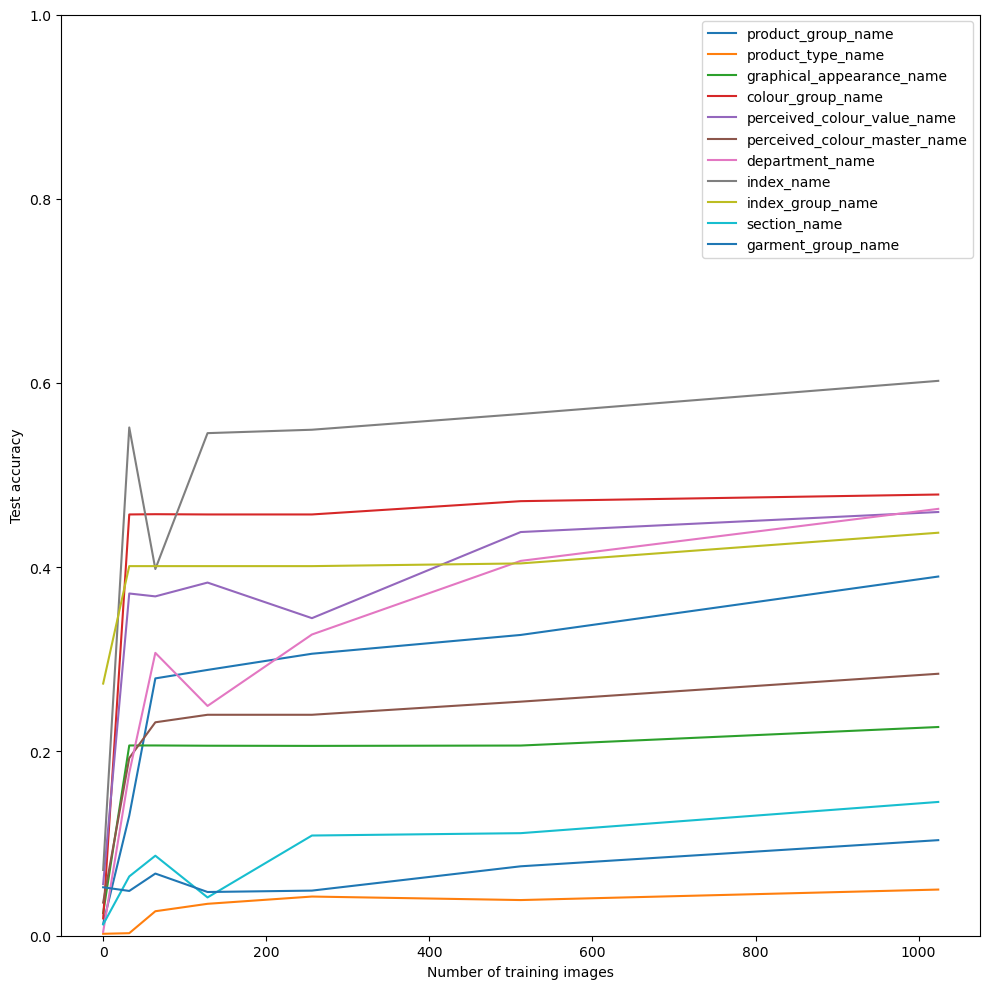

<Figure size 640x480 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
import numpy as np

test_acc = []
test_acc.append([0.0129, 0.0021, 0.02467, 0.01879, 0.05599, 0.03597, 0.00417, 0.07137, 0.2737, 0.01224, 0.05258])
test_acc.append([0.1303, 0.00275, 0.20653, 0.45729, 0.37149, 0.19286, 0.17673, 0.55173, 0.4012, 0.06435, 0.0486])
test_acc.append([0.27933, 0.02658, 0.20653, 0.45757, 0.36836, 0.23168, 0.30704, 0.39806, 0.4012, 0.08685, 0.06748])
test_acc.append([0.28853, 0.03464, 0.20625, 0.45729, 0.38335, 0.23984, 0.24943, 0.54556, 0.4012, 0.04157, 0.04746])
test_acc.append([0.30609, 0.04252, 0.20606, 0.45729, 0.34472, 0.23984, 0.32697, 0.54926, 0.4012, 0.10877, 0.04897])
test_acc.append([0.3265, 0.03872, 0.20644, 0.47172, 0.43821, 0.25408, 0.40689, 0.56634, 0.40414, 0.11133, 0.07536])
test_acc.append([0.3899, 0.05011, 0.22656, 0.47893, 0.45995, 0.28436, 0.46336, 0.60232, 0.43745, 0.14522, 0.10374])
test_acc = np.array(test_acc)

train_image_counts = np.array([0, 32, 64, 128, 256, 512, 1024])
class_names = ['product_group_name', 'product_type_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name']

plt.figure(figsize=(10, 10))
for i in range(11):
    plt.plot(train_image_counts, test_acc[:, i], label=class_names[i])
plt.legend()
plt.xlabel('Number of training images')
plt.ylabel('Test accuracy')
plt.ylim(0, 1.0)
# plt.xscale('log')
plt.tight_layout()
plt.show()

# save the plot
plt.savefig('plot.png')